In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np 
import pandas as pd 

from datetime import date, timedelta, datetime 
import time
#https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [16]:
ab_path = "data/SPY-Daily-Y09-Now.csv"
asset_name='SP500'
date_col='Date'
# feature_cols=['EMA1', 'EMA2', 'MACD', 'RSI']
feature_cols=['EMA1','MACD', 'RSI']
target_col_index=0  # specigy index from feature_cols

start_date='2022-01-01'
end_date='2022-12-31'

main_obj_metric='mean_absolute_error'
main_loss='mean_absolute_error'

split_fraction = 0.8


step = 1

past = 20
future = 5
learning_rate = 0.001
batch_size = 32
epochs = 50

n_early=10  #10/15/20

n_input_neurons=120

In [17]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':date_col},inplace=True)
df.drop(columns=['Ticker'],inplace=True)
allCols=list(df.columns)
print(allCols)

df[date_col]=df[date_col].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index(date_col,inplace=True)
df=df.loc[start_date:end_date,:]
df=df[feature_cols]
print(df.info())
df.tail()

['Date', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-01-03 to 2022-12-30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EMA1    251 non-null    float64
 1   MACD    251 non-null    float64
 2   RSI     251 non-null    float64
dtypes: float64(3)
memory usage: 7.8 KB
None


,EMA1,MACD,RSI
Date,,,
2022-12-23,386.73,-3.11,43.83
2022-12-27,385.76,-3.28,42.73
2022-12-28,384.11,-3.75,39.42
2022-12-29,383.99,-3.45,45.85
2022-12-30,383.70,-3.26,45.09


In [7]:
# def show_heatmap(data):
#     plt.matshow(data.corr())
#     plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
#     plt.gca().xaxis.tick_bottom()
#     plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

#     cb = plt.colorbar()
#     cb.ax.tick_params(labelsize=14)
#     plt.title("Feature Correlation Heatmap", fontsize=14)
#     plt.show()


# show_heatmap(df)

In [10]:

train_split = int(split_fraction * int(df.shape[0]))
print(f"{train_split}={split_fraction} x {int(len(df.shape))}")



200=0.8 x 2


In [11]:
features=df.copy()
print(features.info())
features.tail()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-01-03 to 2022-12-30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EMA1    251 non-null    float64
 1   MACD    251 non-null    float64
 2   RSI     251 non-null    float64
dtypes: float64(3)
memory usage: 7.8 KB
None


,EMA1,MACD,RSI
Date,,,
2022-12-23,386.73,-3.11,43.83
2022-12-27,385.76,-3.28,42.73
2022-12-28,384.11,-3.75,39.42
2022-12-29,383.99,-3.45,45.85
2022-12-30,383.70,-3.26,45.09


In [12]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0) # nomoalize only train data
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
print(features.info())
features.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       251 non-null    float64
 1   1       251 non-null    float64
 2   2       251 non-null    float64
dtypes: float64(3)
memory usage: 6.0 KB
None


,0,1,2
246,-1.037575,-0.172537,-0.203613
247,-1.071431,-0.209333,-0.314858
248,-1.129019,-0.311061,-0.649603
249,-1.133207,-0.246128,0.000673
250,-1.143329,-0.205004,-0.076187


In [13]:
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]
print(train_data.shape,val_data.shape)

(200, 3) (51, 3)


In [14]:
start = past + future
end = start + train_split

sequence_length = int(past / step)

print(f"start={start} and end={end} and sequence_length={sequence_length}")

start=25 and end=225 and sequence_length=20


In [142]:
x_train = train_data[[i for i in range(len(feature_cols))]].values
print(x_train.shape)
print(x_train[:5])

(1611, 1)
[[-1.09233502]
 [-1.10774872]
 [-1.12683234]
 [-1.1339887 ]
 [-1.12793332]]


In [143]:
y_train = features.iloc[start:end][[target_col_index]]
print(y_train.shape)
print(y_train[:5])

(1611, 1)
           0
70 -1.047195
71 -1.042057
72 -1.045910
73 -1.042791
74 -1.040956


In [144]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)
print(dataset_train)

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [145]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(len(feature_cols))]].values
y_val = features.iloc[label_start:][[target_col_index]]



In [146]:
print(x_val.shape)
print(x_val[:5])

(333, 1)
[[2.76916233]
 [2.77998861]
 [2.78751196]
 [2.79595279]
 [2.79760426]]


In [147]:
print(y_val.shape)
print(y_val[:5])

(333, 1)
             0
1681  3.385894
1682  3.387545
1683  3.382591
1684  3.366626
1685  3.357268


In [148]:

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)


Input shape: (32, 60, 1)
Target shape: (32, 1)


In [149]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(n_input_neurons)(inputs)
outputs = keras.layers.Dense(future)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',loss=main_loss,metrics=[main_obj_metric])
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 120)               58560     
                                                                 
 dense_4 (Dense)             (None, 10)                1210      
                                                                 
Total params: 59,770
Trainable params: 59,770
Non-trainable params: 0
_________________________________________________________________


In [151]:
path_checkpoint = f"model_{asset_name}_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=n_early)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/150
48/49 [============================>.] - ETA: 0s - loss: 0.4268 - mean_absolute_error: 0.4268
Epoch 1: val_loss improved from inf to 0.71553, saving model to model_SP500_checkpoint.h5
49/49 [==============================] - 5s 60ms/step - loss: 0.4281 - mean_absolute_error: 0.4281 - val_loss: 0.7155 - val_mean_absolute_error: 0.7155
Epoch 2/150
48/49 [============================>.] - ETA: 0s - loss: 1.1099 - mean_absolute_error: 1.1099
Epoch 2: val_loss did not improve from 0.71553
49/49 [==============================] - 2s 47ms/step - loss: 1.1221 - mean_absolute_error: 1.1221 - val_loss: 2.4325 - val_mean_absolute_error: 2.4325
Epoch 3/150
48/49 [============================>.] - ETA: 0s - loss: 0.7050 - mean_absolute_error: 0.7050
Epoch 3: val_loss did not improve from 0.71553
49/49 [==============================] - 2s 48ms/step - loss: 0.7216 - mean_absolute_error: 0.7216 - val_loss: 2.4188 - val_mean_absolute_error: 2.4188
Epoch 4/150
49/49 [=======================

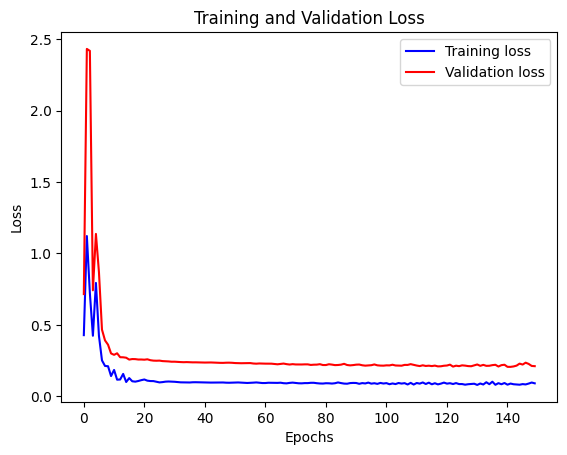

In [152]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [153]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/